In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Enable GPU usage if available
import tensorflow as tf

In [15]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used")
    # Configure memory growth to avoid memory allocation issues
    for gpu in tf.config.experimental.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU found, using CPU instead")


GPU is available and will be used


In [16]:
# Try different import approaches for TensorFlow/Keras
try:
    # For newer TensorFlow versions where Keras is separate
    import keras
    from keras import layers
    print("Using standalone Keras:", keras.__version__)
except ImportError:
    try:
        # For older TensorFlow versions
        from tensorflow import keras
        from tensorflow.keras import layers
        print("Using TensorFlow Keras:", tf.__version__)
    except ImportError:
        # If standalone Keras is installed
        import keras
        from keras import layers
        print("Using standalone Keras (fallback):", keras.__version__)


Using standalone Keras: 3.6.0


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, confusion_matrix

# Get the current working directory and adjust paths accordingly
current_dir = os.getcwd()
if current_dir.endswith('src'):
    # If running from src directory
    data_path = "../dataset/cleaned_BizPlay_2024_DEC.csv"
    model_save_path = "../models/autoencoder_model.keras"
else:
    # If running from project root
    data_path = "dataset/cleaned_dataset.csv"
    model_save_path = "models/autoencoder_model.keras"


In [18]:
df = pd.read_csv(data_path)

# Add date-based features
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], format='%Y-%m-%d', errors='coerce')
df['day_of_week'] = df['Transaction Date'].dt.dayofweek  # Monday=0, Sunday=6
df['month'] = df['Transaction Date'].dt.month
df['day_of_month'] = df['Transaction Date'].dt.day

df

,Transaction Date,Transaction Time,Transaction Amount,Customer Date of Birth,Customer Gender,Customer Age,Customer Region (City/County/District),Merchant Region (City/County/District),Merchant ID,Sub-Merchant ID,Transaction Processing Agency (VAN),Distance,anomaly,day_of_week,month,day_of_month
0,NaT,231124,-38500,70613,0,17,32,59,0,0,2,0,1,NaN,NaN,NaN
1,NaT,225957,-24900,60616,0,18,16,59,0,0,2,0,0,NaN,NaN,NaN
2,NaT,225944,35000,100216,0,15,34,59,0,40403,2,0,0,NaN,NaN,NaN
3,NaT,225937,24900,60616,0,18,16,59,0,0,2,0,0,NaN,NaN,NaN
4,NaT,225935,2500,71026,1,17,17,26,1,13424,3,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256498,NaT,60704,7700,120111,0,13,36,47,1,30364,3,12,0,NaN,NaN,NaN
256499,NaT,60347,4700,60103,0,19,4,13,1,23484,3,0,0,NaN,NaN,NaN
256500,NaT,60205,3750,100928,1,14,10,19,1,30108,3,0,0,NaN,NaN,NaN
256501,NaT,60158,12600,160405,0,9,10,19,1,6636,3,0,0,NaN,NaN,NaN


In [19]:
# Define features and target
features = [
    'Transaction Amount',
    'Customer Gender',
    'Customer Age',
    'Customer Region (City/County/District)',
    'Merchant Region (City/County/District)',
    'Merchant ID',
    'Sub-Merchant ID',
    'Transaction Processing Agency (VAN)',
    'Distance',
    'day_of_week',
    'month',
    'day_of_month'
]

target = 'anomaly'
X = df[features]
y = df[target]

In [20]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,    # Keep the same anomaly/normal ratio
    random_state=42
)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


/home/sokheang/miniconda3/envs/abnormal_transaction_detection_env/lib/python3.12/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/sokheang/miniconda3/envs/abnormal_transaction_detection_env/lib/python3.12/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/sokheang/miniconda3/envs/abnormal_transaction_detection_env/lib/python3.12/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [21]:
# Filter only normal transactions for training the autoencoder
X_train_normal = X_train_scaled[y_train == 0]

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the autoencoder model
input_dim = X_train_scaled.shape[1]  # number of features


In [22]:
# Build a deeper autoencoder with more capacity
try:
    # First approach
    autoencoder = keras.Sequential([
        # Encoder
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        
        # Bottleneck
        layers.Dense(8, activation='relu'),
        
        # Decoder
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        
        # Output layer
        layers.Dense(input_dim, activation='linear')
    ])
except Exception as e:
    print(f"First approach failed: {e}")
    # Alternative approach
    inputs = layers.Input(shape=(input_dim,))
    # Encoder
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    # Bottleneck
    x = layers.Dense(8, activation='relu')(x)
    # Decoder
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    # Output
    outputs = layers.Dense(input_dim, activation='linear')(x)
    
    autoencoder = keras.Model(inputs, outputs)

In [23]:
# Compile the model
try:
    autoencoder.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse'
    )
except Exception as e:
    print(f"First compile approach failed: {e}")
    # Alternative compile approach
    autoencoder.compile(
        optimizer='adam',
        loss='mse'
    )

# Display the model summary
autoencoder.summary()

# Train the autoencoder on normal data only
try:
    # First approach with early stopping
    history = autoencoder.fit(
        X_train_normal, X_train_normal,  # Autoencoder tries to reconstruct the input
        epochs=50,
        batch_size=256,
        validation_split=0.2,
        shuffle=True,
        verbose=1,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            # Add TensorBoard callback for monitoring GPU usage
            keras.callbacks.TensorBoard(
                log_dir='../logs/autoencoder',
                histogram_freq=1,
                profile_batch='500,520'  # Profile a few batches for performance analysis
            )
        ]
    )
except Exception as e:
    print(f"Training with callbacks failed: {e}")
    # Simpler approach without callbacks
    history = autoencoder.fit(
        X_train_normal, X_train_normal,
        epochs=30,  # Reduced epochs since we don't have early stopping
        batch_size=256,
        validation_split=0.2,
        shuffle=True,
        verbose=1,
        # Add simple TensorBoard logging without profiling
        callbacks=[
            keras.callbacks.TensorBoard(log_dir='../logs/autoencoder_fallback')
        ]
    )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,156 (27.95 KB)

 Trainable params: 7,156 (27.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2025-04-29 16:31:06.902950: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-04-29 16:31:06.902972: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-04-29 16:31:06.943838: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2025-04-29 16:31:06.949615: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1036] CUPTI activity buffer flushed


520/528 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan  

2025-04-29 16:31:09.350762: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-04-29 16:31:09.350782: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-04-29 16:31:09.434186: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:68] Profiler session collecting data.
2025-04-29 16:31:09.440054: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1036] CUPTI activity buffer flushed
2025-04-29 16:31:09.454055: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:534]  GpuTracer has collected 993 callback api events and 970 activity events. 
2025-04-29 16:31:09.460618: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2025-04-29 16:31:09.460719: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:147] Collecting XSpace to repository: ../logs/autoencoder/plugins/profile/2025_04_29_16_31_09/workstation.xplane.pb


528/528 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: nan - val_loss: nan
Epoch 2/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - loss: nan - val_loss: nan
Epoch 3/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan
Epoch 4/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan
Epoch 5/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - val_loss: nan


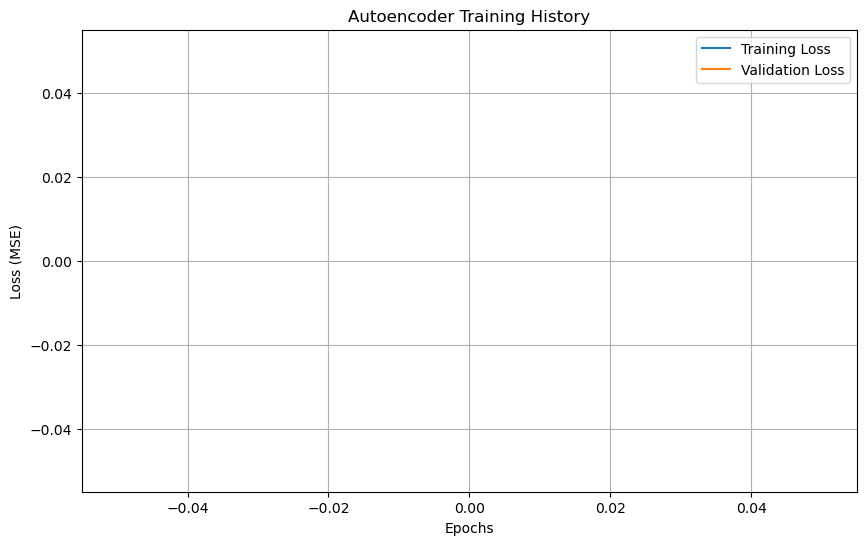

In [24]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Calculate reconstruction error on the entire dataset
# Use GPU acceleration for prediction if available
with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    X_test_pred = autoencoder.predict(X_test_scaled, batch_size=512)  # Larger batch size for GPU
mse = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

# Plot the distribution of reconstruction errors
# plt.figure(figsize=(12, 6))
# plt.hist(mse[y_test == 0], bins=50, alpha=0.5, label='Normal')
# plt.hist(mse[y_test == 1], bins=50, alpha=0.5, label='Anomaly')
# plt.xlabel('Reconstruction Error (MSE)')
# plt.ylabel('Count')
# plt.legend()
# plt.title('Distribution of Reconstruction Errors')
# plt.grid(True)
# plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


In [ ]:
# Find the optimal threshold
# We'll use the 95th percentile of reconstruction errors on normal data
threshold = np.percentile(mse[y_test == 0], 95)
print(f"Threshold: {threshold}")

# Make predictions based on the threshold
y_pred = (mse > threshold).astype(int)

# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# # Plot ROC curve
# fpr, tpr, _ = roc_curve(y_test, mse)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(10, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()

Threshold: nan
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/home/sokheang/miniconda3/envs/abnormal_transaction_detection_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: Input contains NaN.

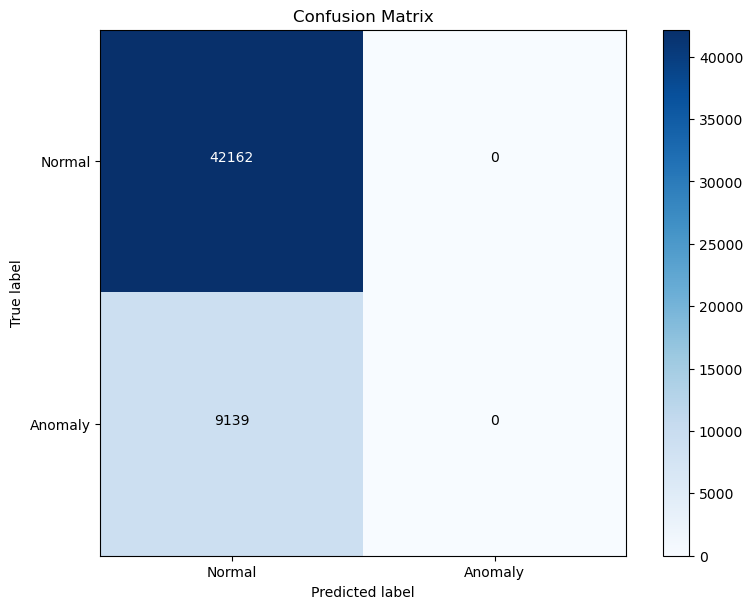

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal', 'Anomaly'])
plt.yticks(tick_marks, ['Normal', 'Anomaly'])

# Add text annotations to the confusion matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Save the model
autoencoder.save(model_save_path)

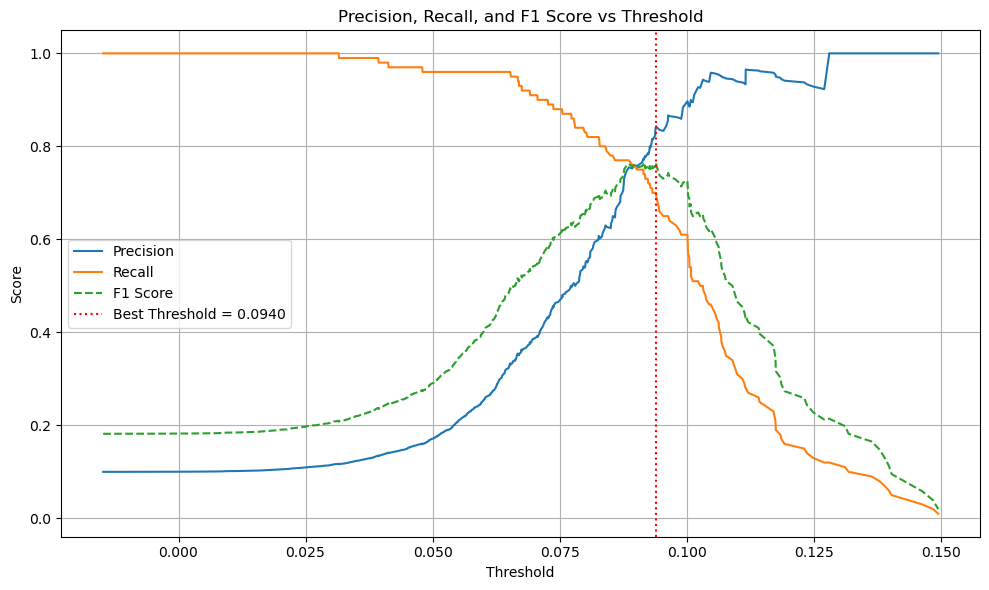

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Simulated reconstruction errors and true labels for demonstration
np.random.seed(42)
reconstruction_errors = np.random.normal(loc=0.05, scale=0.02, size=1000)
true_labels = np.zeros(1000)
true_labels[:100] = 1  # 100 anomalies

# Make anomalies more extreme
reconstruction_errors[true_labels == 1] += np.random.normal(loc=0.05, scale=0.02, size=100)

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(true_labels, reconstruction_errors)

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# Plot precision-recall vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', linestyle='--')
plt.axvline(best_threshold, color='red', linestyle=':', label=f'Best Threshold = {best_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
